In [3]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 64000, 1)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 6400, 80)          2480      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2133, 80)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2127, 60)          33660     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 709, 60)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 703, 60)           25260     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 234, 60)          

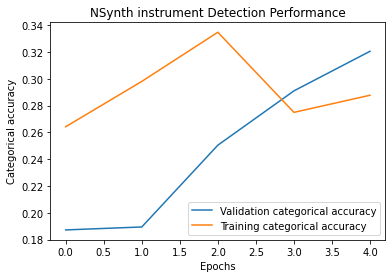

In [6]:
from keras import layers
from loguru import logger
import matplotlib.pyplot as plt


def _one_hot(tensor: tf.Tensor, size) -> tf.Tensor:
    """
    One hot encode a tensor and return it as 1D tensor
    :param tensor:
    :param size: number of unique values in tensor
    :return:
    """
    hot_tensor = tf.one_hot(tensor, size)
    shaped_tensor = tf.reshape(hot_tensor, (size,))
    return shaped_tensor


@tf.autograph.experimental.do_not_convert
def _parse_function(example_proto):
    # Schema
    features = {
        "pitch": tf.io.FixedLenFeature([1], dtype=tf.int64),
        "audio": tf.io.FixedLenFeature([64000], dtype=tf.float32),
        "velocity": tf.io.FixedLenFeature([1], dtype=tf.int64),
        "instrument_family": tf.io.FixedLenFeature([1], dtype=tf.int64),
    }
    example = tf.io.parse_single_example(example_proto, features)
    data = example['audio']
    label_name = 'instrument_family'
    label_value_count = 11
    # label_name = 'velocity'
    # label_value_count = 4
    label = _one_hot(example[label_name], label_value_count)
    return data, label
def run():
    DATA_PATH_VALID = '../data/nsynth-valid.tfrecord'
    DATA_PATH_TEST = '../data/nsynth-test.tfrecord'
    batch_size = 32
    audio_length = 64_000
    parsed_dataset = tf.data \
        .TFRecordDataset(DATA_PATH_VALID) \
        .map(_parse_function) \
        .batch(batch_size)
    
    parsed_test = tf.data \
        .TFRecordDataset(DATA_PATH_TEST) \
        .map(_parse_function) \
        .batch(batch_size) 
    # print(parsed_dataset.shapes )
    model = tf.keras.Sequential([
        layers.Input(shape=(audio_length,)),
        layers.Reshape(target_shape=(audio_length, 1)),
        layers.Conv1D(80, 30, activation='relu', strides=10, padding="SAME"),
        layers.MaxPooling1D(3, strides=3),
        layers.Conv1D(60, 7, activation='relu'),
        layers.MaxPooling1D(3, strides=3),
        layers.Conv1D(60, 7, activation='relu'),
        layers.MaxPooling1D(3, strides=3),
        layers.Flatten(),
        layers.Dense(11, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )
    model.summary()
    history = model.fit(parsed_dataset, epochs=5, validation_data=parsed_test)
    model.save("../models/0505instrumentclassifier_5epoch")
    plt.plot(history.history['val_categorical_accuracy'], label='Validation categorical accuracy')
    plt.plot(history.history['categorical_accuracy'], label='Training categorical accuracy')
    plt.legend()
    plt.title('NSynth instrument Detection Performance')
    plt.xlabel('Epochs')
    plt.ylabel('Categorical accuracy')
    plt.savefig('model')
if __name__ == "__main__":
    run()